In [ ]:
from typing import Union, Literal
import numpy as np

def pcs_convergence_mccand_r(
    iteration: int,
    current_energy: float,
    memory_matrix: np.ndarray,
    stability_criterion: float = 1e-6,
    output: Literal["qualitative", "quantitative"] = "qualitative"
) -> Union[bool, int]:
    """
    Check a PCS network for convergence using McClelland and Rumelhart's criterion.

    This function determines whether a network has converged by examining energy changes
    across iterations. Convergence is achieved when energy changes remain below a
    threshold for a sufficient number of consecutive iterations.

    Args:
        iteration: The iteration to consider (typically current iteration during simulation).
        current_energy: The current energy level within the network.
        memory_matrix: Array of shape (n_iterations, n_features) containing iteration number,
            energy, and node states for all previous iterations. Energy values should be
            in column index 1.
        stability_criterion: Threshold below which energy changes are considered
            insignificant. Default is 1e-6.
        output: Either "qualitative" (returns boolean indicating convergence) or
            "quantitative" (returns count of iterations meeting criterion). Default
            is "qualitative".

    Returns:
        If output=="qualitative": Boolean indicating whether convergence criterion is met.
        If output=="quantitative": Integer count of how many of the last 10 iterations
        met the stability criterion.
    """
    #  first 10 iterations, always true (network still stabilizing)
    if iteration <= 10:
        return True

    # energy values for last 11 iterations (to compute 10 changes)
    energy_values = memory_matrix[iteration-10:iteration+1, 1]

    # Calculate changes in energy between consecutive iterations
    energy_changes = np.abs(energy_values[:-1] - energy_values[1:])

    # Count how many changes are below threshold
    changes_below_threshold = np.sum(energy_changes < stability_criterion)

    if output == "quantitative":
        return int(changes_below_threshold)
    else:
        # Return True if we haven't reached 10 stable iterations yet
        return changes_below_threshold < 10

In [ ]:
import numpy as np
from typing import Union, Tuple

def pcs_iterate(
    interconnection_matrix: np.ndarray,
    state: np.ndarray,
    resting_levels: np.ndarray,
    decay_rate: float = 0.1,
    floor: float = -1.0,
    ceiling: float = 1.0
) -> np.ndarray:
    """
    Calculate a new state given an interconnection matrix and previous state.

    Args:
        interconnection_matrix: Square matrix of connection weights between nodes
        state: Current activation state of nodes
        resting_levels: Baseline activation levels for nodes
        decay_rate: Rate at which node activations decay to resting levels
        floor: Minimum activation value
        ceiling: Maximum activation value

    Returns:
        Updated state vector for all nodes
    """
    # Calculate net inputs as weighted sum across the matrix
    net_inputs = state @ interconnection_matrix

    # Calculate change based on net inputs
    # Positive inputs push toward ceiling, negative inputs push toward floor
    positive_mask = net_inputs >= 0
    change = (
        (positive_mask * net_inputs * (ceiling - state)) +
        (~positive_mask * net_inputs * (-floor + state))
    )

    # Calculate node decay towards resting levels
    decay = decay_rate * (state - resting_levels)

    # Return updated state
    return state - decay + change

def pcs_energy(interconnection_matrix: np.ndarray, state: np.ndarray) -> float:
    """
    Calculates the energy present in the model given current state.

    Lower energy indicates a more stable state. The negative sign ensures
    that stable states have lower energy.

    Args:
        interconnection_matrix: Square matrix of connection weights between nodes
        state: Current activation state of nodes

    Returns:
        Scalar value representing system energy
    """
    return float(-1.0 * (state @ interconnection_matrix @ state))

def pcs_reset(state: np.ndarray, reset: np.ndarray) -> np.ndarray:
    """
    Reset specified nodes to their fixed activation values.

    Args:
        state: Current activation state of nodes
        reset: Vector specifying which nodes should be reset and to what values.
               Non-zero values indicate nodes to reset.

    Returns:
        Updated state vector with specified nodes reset
    """
    reset_mask = reset != 0
    return np.where(reset_mask, reset, state)

In [ ]:
import numpy as np
import pandas as pd
from typing import List, Callable, Union, Dict, Optional



def pcs_run(interconnection_matrix: np.ndarray,
            initial_state: np.ndarray,
            resting_levels: np.ndarray,
            reset: np.ndarray,
            node_names: Optional[List[str]] = None,
            stability_criterion: float = 1e-6,
            max_iterations: float = float('inf'),
            convergence_criteria: Optional[List[Callable]] = None,
            convergence_names: Optional[List[str]] = None) -> Dict:
    """
    Simulate the run of a PCS model.

    Args:
        interconnection_matrix: Square matrix representing link weights between nodes.
        initial_state: Initial node activations before first iteration.
        resting_levels: Resting activation level for each node.
        reset: Vector denoting nodes with stable activation values.
        node_names: Human-readable labels for every node.
        stability_criterion: Stability threshold for convergence criteria.
        max_iterations: Maximum number of iterations before termination.
        convergence_criteria: Array of convergence criteria functions.
        convergence_names: Human-readable labels for convergence criteria.

    Returns:
        Dict containing model iterations and convergence information.
    """
    # Set default convergence criteria if none provided
    if convergence_criteria is None:
        convergence_criteria = [pcs_convergence_mccand_r]

    iteration = 0
    n_criteria = len(convergence_criteria)

    # Set default convergence names if none provided
    if convergence_names is None:
        convergence_names = [f"criterion_{i+1}" for i in range(n_criteria)]

    # Initialize model state
    state = initial_state.copy()
    state = pcs_reset(state, reset)
    nodes = len(state)
    energy = pcs_energy(interconnection_matrix, state)

    # Initialize storage for iterations and convergence
    max_memory = 1000  # Initial size, can be adjusted
    memory_matrix = np.zeros((max_memory, nodes + 2))  # +2 for iteration and energy
    convergence_matrix = np.zeros((max_memory, n_criteria), dtype=bool)

    # Store initial state
    memory_matrix[iteration] = np.concatenate(([iteration, energy], state))
    convergence_matrix[iteration] = [True] * n_criteria

    # Main simulation loop
    continue_simulation = True
    while continue_simulation and iteration < max_iterations:
        iteration += 1

        # Compute new state and energy
        state = pcs_iterate(interconnection_matrix, state, resting_levels)
        state = pcs_reset(state, reset)
        energy = pcs_energy(interconnection_matrix, state)

        # Store current state
        if iteration >= max_memory:
            # Expand matrices if needed
            new_size = max_memory * 2
            memory_matrix = np.pad(memory_matrix, ((0, new_size - max_memory), (0, 0)))
            convergence_matrix = np.pad(convergence_matrix, ((0, new_size - max_memory), (0, 0)))
            max_memory = new_size

        memory_matrix[iteration] = np.concatenate(([iteration, energy], state))

        # Check convergence criteria
        for f_idx, criterion_func in enumerate(convergence_criteria):
            convergence_matrix[iteration, f_idx] = criterion_func(
                iteration=iteration,
                current_energy=energy,
                memory_matrix=memory_matrix[:iteration+1],
                stability_criterion=stability_criterion
            )

        # Continue until all criteria are met
        continue_simulation = np.any(convergence_matrix[iteration])

    # Prepare output
    memory_df = pd.DataFrame(
        memory_matrix[:iteration+1],
        columns=['iteration', 'energy'] +
                (node_names if node_names is not None else [f'node_{i}' for i in range(nodes)])
    )

    convergence_counts = np.sum(convergence_matrix[:iteration+1], axis=0)

    return {
        'iterations': memory_df,
        'convergence': dict(zip(convergence_names, convergence_counts))
    }



In [ ]:
def pcs_run_from_interconnections(
    interconnection_matrix: np.ndarray,
    convergence_criteria: Optional[List[Callable]] = None,
    convergence_names: Optional[Union[str, List[str]]] = "default"
) -> Dict:
    """
    Simulate PCS model using only interconnection matrix with default parameters.

    Args:
        interconnection_matrix: Square matrix representing link weights between nodes.
        convergence_criteria: Array of convergence criteria functions.
        convergence_names: Labels for convergence criteria.

    Returns:
        Dict containing model iterations and convergence information.
    """
    nodes = len(interconnection_matrix)

    #defaults
    if convergence_criteria is None:
        convergence_criteria = [pcs_convergence_mccand_r]
    if convergence_names == "default":
        convergence_names = [f"criterion_{i+1}" for i in range(len(convergence_criteria))]


    resting_levels = np.zeros(nodes)
    initial_state = np.zeros(nodes)

    # first node : constant activation
    reset = np.zeros(nodes)
    reset[0] = 1

    return pcs_run(
        interconnection_matrix=interconnection_matrix,
        initial_state=initial_state,
        resting_levels=resting_levels,
        reset=reset,
        convergence_criteria=convergence_criteria,
        convergence_names=convergence_names
    )

In [ ]:
import numpy as np
def matrix_manipulation (data):
  #data=np.loadtxt("D1.csv", delimiter=",", dtype=float)
  interconnection_matrix = np.zeros((17,17))
  #print (data)
  for i in range (12):
    interconnection_matrix[0, 1+i] = data[i, 0]


  sourceNodeCueW = interconnection_matrix[0, 1:13]
  sourceNodeCueW= np.array(sourceNodeCueW)
  sourceNodeCueW = (sourceNodeCueW) * 1 ** 1.9
  interconnection_matrix[0,1:13] = sourceNodeCueW
  #print (interconnection_matrix)
  cueOptionScale = 0.01

  for i in range (4):
    for j in range (12):

      interconnection_matrix[j+1, i+13] = data[j, i+1] * cueOptionScale


  #print(interconnection_matrix)
  for i in range (3):
    for j in range(4):
      interconnection_matrix[i+13, j+13] = -0.2
  #print (interconnection_matrix)

  interconnection_matrix = np.array(interconnection_matrix)

  upper_tri = np.triu(np.ones_like(interconnection_matrix), k=1)
  symmetric_part= np.transpose(upper_tri*interconnection_matrix)
  #print (symmetric_part)
  interconnection_matrix += symmetric_part

  interconnection_matrix = interconnection_matrix.reshape(17, 17)
  np.fill_diagonal(interconnection_matrix, 0)
  #print (interconnection_matrix)



  final=pcs_run_from_interconnections(interconnection_matrix)
  #print (final)
  return final




iteration    135.000000
energy        -3.453041
node_0         1.000000
node_1         0.859664
node_2         0.740113
node_3         0.715565
node_4         0.643853
node_5         0.666193
node_6         0.589931
node_7         0.607188
node_8         0.552005
node_9         0.501950
node_10        0.455615
node_11        0.362659
node_12        0.345477
Hatsdun        0.523836
Kaiwa          0.727743
Dasuka        -0.561838
Nabusi        -0.644058
Name: 135, dtype: float64


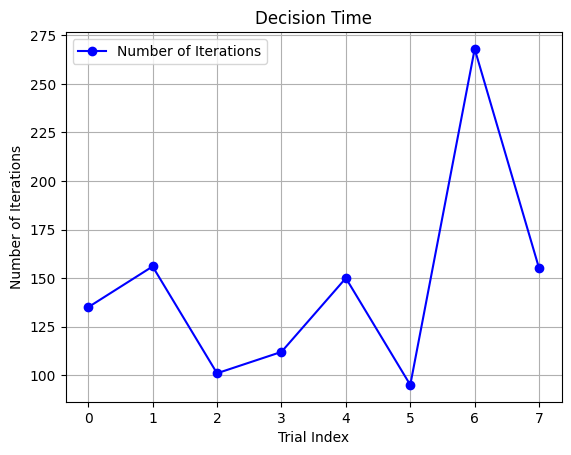

the final choice made by the consumer should be Kaiwa


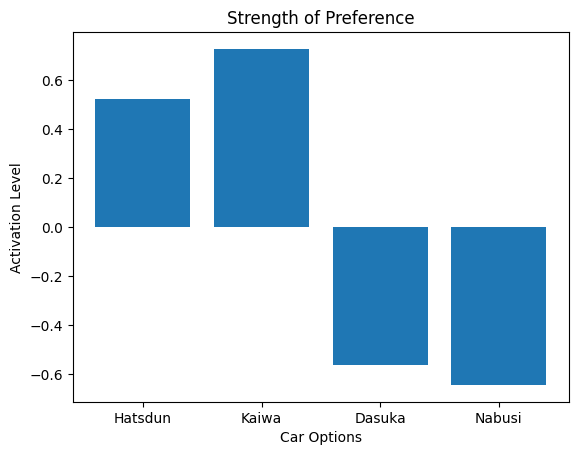

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
def results ():
  data1=np.loadtxt("D1.csv", delimiter=",", dtype=float)
  data2=np.loadtxt("D2.csv", delimiter=",", dtype=float)
  data3=np.loadtxt("D3.csv", delimiter=",", dtype=float)
  data4=np.loadtxt("D4.csv", delimiter=",", dtype=float)
  data5=np.loadtxt("D5.csv", delimiter=",", dtype=float)
  data6=np.loadtxt("D6.csv", delimiter=",", dtype=float)
  data7=np.loadtxt("D7.csv", delimiter=",", dtype=float)
  data8=np.loadtxt("D8.csv", delimiter=",", dtype=float)

  all_data= [data1, data2, data3, data4, data5, data6, data7, data8]

  final=matrix_manipulation(data1)
  act= final['iterations']
  #print(type(act))
  act=pd.DataFrame(act)
 # print(act)
  num_rows, num_cols = act.shape
  act = act.rename(columns={'node_13': 'Hatsdun', 'node_14': 'Kaiwa', 'node_15': 'Dasuka', 'node_16': 'Nabusi'})

  final_levels=act.iloc[num_rows-1]
  print(final_levels)


  iters=[0, 0, 0, 0, 0, 0, 0, 0]

  for i in range (len(all_data)):
    final_levels=matrix_manipulation(all_data[i])
    act_level=final_levels['iterations']
    act_levels=pd.DataFrame(act_level)
    rows, cols= act_levels.shape
    n_iterations= act_levels.iloc[rows-1, 0]
    iters[i]=n_iterations

  plt.plot(iters, marker='o', linestyle='-', color='b', label='Number of Iterations')

  # Add labels and title
  plt.title('Decision Time')
  plt.xlabel('Trial Index')
  plt.ylabel('Number of Iterations')

  # Add a legend
  plt.legend()

  # Display the graph
  plt.grid(True)
  plt.show()



  final_choice = act.iloc[num_rows-1, -4:].idxmax()
  print(f'the final choice made by the consumer should be {final_choice}')
  final_cars_level= act.iloc[num_rows-1, -4:]
  plt.bar(final_cars_level.index, final_cars_level.values)
  plt.xlabel('Car Options')
  plt.ylabel('Activation Level')
  plt.title('Strength of Preference')
  plt.show()









results()